# Final Project

For the following project, you will be working with a movie dataset. The dataset is [here](https://drive.google.com/file/d/1R53inu8Jcb9GGoyiuVnBMVnO7XvCaJAE/view?usp=drive_link). The dataset columns are as follows:

* Title: The movie's title
* Genre: The movie's genre
* Stars: The number of famous actors in the movie
* Runtime: The length of the movie's runtime
* Budget: How much was spent on filming the movie (in millions)
* Promo: How much money was spent promoting the movie (in millions)
* Season: The season in which the movie was released
* Rating: The movie's rating
* R1: Reviewer 1's review
* R1: Reviewer 2's review
* R1: Reviewer 3's review

And the target variable:

* Success: Whether the film was a success or a flop

Fill in the answers to questions in the text field, and show your code below.

# Data loading

Load the data

In [14]:
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import sklearn

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

file_path = 'CMSC320FinalProjectData.csv'
df = pd.read_csv(file_path)

# Data Cleaning

List the three biggest data errors below, with a summary of how you fixed them and why you choose that method:


* Stars has invalid value such as 100. So I replaced the invalid values with the mode
* Budget has a lot incorrect number such as 108475311.7 million (incosistent unit). For such case, I devide all the value over 1000 by 1 million
* Runtime has invalid 0, I will replace them by the mean.

In [15]:
star_mode = df['Stars'].mode()
df.loc[(df['Stars'] > 5) | (df['Stars'] < 0), 'Stars'] = star_mode


df.loc[df['Budget'] > 1000, 'Budget'] /= 1000000

runtime_mean = df[df['Runtime'] != 0]['Runtime'].mean()
df.loc[df['Runtime'] == 0, 'Runtime'] = runtime_mean

# Data Exploration





Does Season have a stastically significant impact on a movie's success?

Null Hypothesis: There is no significant association between season and movie's success.

Alternative Hypothesis: There is a significant association between season and movie's success.

**p-value:** 0.005716268505111858

The null hypothesis is rejected. There is a significant association.

In [16]:
contingency_table = pd.crosstab(df['Season'], df['Success'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(p)

0.005716268505111858


Do seasons have a statistically significant difference in their distribution of content ratings?
Null Hypothesis: There is no significant association between season and movie's content rating.

Alternative Hypothesis: There is a significant association between season and movie's content rating.

**p-value:** 0.21507814500508263

The null hypothesis is not rejected. There is no significant association.

In [17]:
contingency_table = pd.crosstab(df['Season'], df['Rating'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(p)

0.21507814500508263


Who is the harshest critic (highest precent of negative reviews)?

**Critic:** R1

In [18]:
reviews_r1 = df['R1']
reviews_r2 = df['R2']
reviews_r3 = df['R3']

sia = SentimentIntensityAnalyzer()\

def get_sentiment_polarity(review):
    return sia.polarity_scores(review)['compound']

sentiments_r1 = reviews_r1.apply(get_sentiment_polarity)
sentiments_r2 = reviews_r2.apply(get_sentiment_polarity)
sentiments_r3 = reviews_r3.apply(get_sentiment_polarity)


r1 = (len(list(filter(lambda x: x < 0, sentiments_r1))) / len(sentiments_r1)) * 100
r2 = (len(list(filter(lambda x: x < 0, sentiments_r2))) / len(sentiments_r2)) * 100
r3 = (len(list(filter(lambda x: x < 0, sentiments_r3))) / len(sentiments_r3)) * 100


harshest_reviewer = max([('R1', r1),
                         ('R2', r2),
                         ('R3', r3)],
                        key=lambda x: x[1])

print(f"The harshest reviewer is {harshest_reviewer[0]} with {harshest_reviewer[1]:.2f}% negative reviews.")

The harshest reviewer is R1 with 50.74% negative reviews.


What is the covariance between promotional budget and the filming budget?

**Cov:** 1907.0543228223635

In [19]:
covariance = df['Promo'].cov(df['Budget'])
correlation = df['Promo'].corr(df['Budget'])
print(covariance,correlation)

1907.0543228223635 0.8267148860058207


# Data Visualization

Create a chart that compares the distribution of the budget for each different number of stars. (It does not need to be particularly appealing.

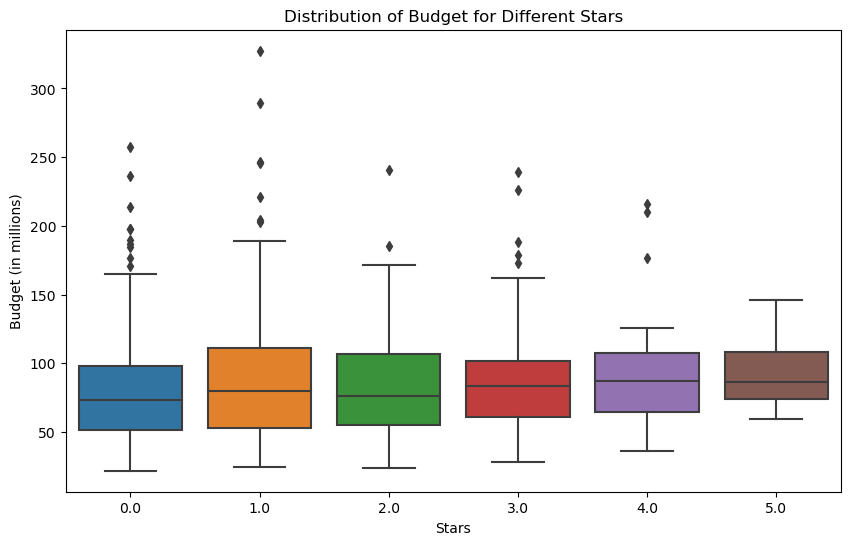

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Stars', y='Budget', data=df)

plt.xlabel('Stars')
plt.ylabel('Budget (in millions)')
plt.title('Distribution of Budget for Different Stars')

plt.show()

Create a graph showing the average movie budget over time.

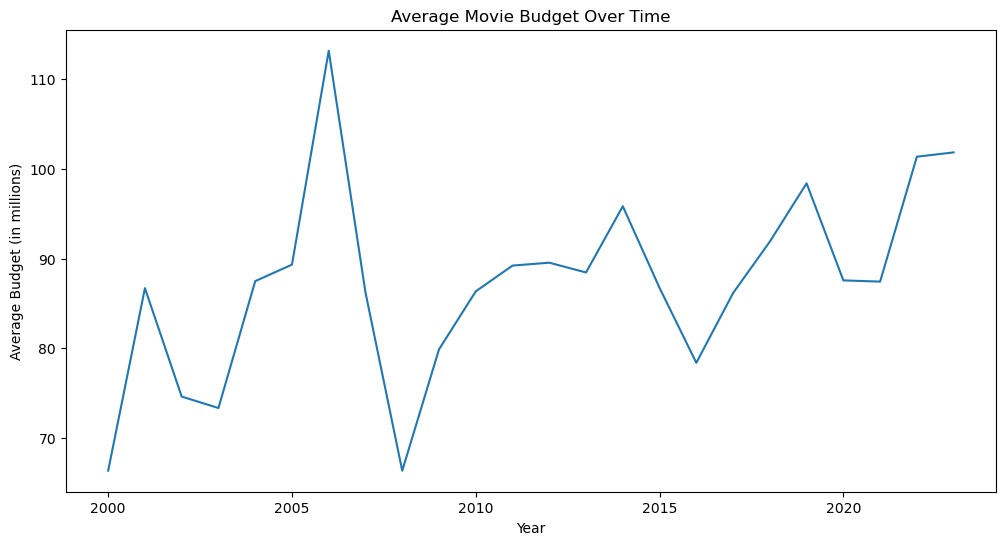

In [21]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Budget', data=df.groupby('Year')['Budget'].mean().reset_index())

plt.xlabel('Year')
plt.ylabel('Average Budget (in millions)')
plt.title('Average Movie Budget Over Time')

plt.show()

# Feature Engineering

List any features you choose to create (if you are creating many features based on one column, you do not need to list them separately.) You are not required to create any features if you do not wish to. You may create any number of additional features.


* Average review : Calculate the average sentiment of the reviews given by 3 reviewers.
* Budget to Promo Ratio: Create a ratio of promotional budget to filming budget.

In [22]:
df['AveReview'] = df[['R1', 'R2', 'R3']].applymap(get_sentiment_polarity).mean(axis=1)
df['BudgetToPromoRatio'] = df['Budget'] / df['Promo']

# Modeling

Create a model of your choice.

**Model type choosen:** Random Forest Classifier

In [23]:
features = ['AveReview', 'BudgetToPromoRatio', 'Season', 'Rating', 'Genre', 'Year', 'Stars','Runtime']
target = 'Success'

# Testing

Shuffle your data and break it into a 10% test set and 90% training set. Show your model's accuracy on the test set. In order to get full credit, the model's accuracy must be higher than 50%.

**Model accuracy:** 0.7777777777777778

In [24]:

df_shuffled = df.sample(frac=1)
df_model = df[features + [target]].dropna()

X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

numeric_features = ['AveReview', 'BudgetToPromoRatio', 'Year', 'Stars', 'Runtime']
categorical_features = ['Season', 'Genre', 'Rating']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

rf_model = RandomForestClassifier(class_weight='balanced')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])


pipeline.fit(X_train, y_train)

# I TRIED TUNNING BUT I GAVE UP
y_probs = pipeline.predict_proba(X_test)[:, 1]
threshold = 0.4
y_pred_adjusted = (y_probs > threshold).astype(int)


test_accuracy = accuracy_score(y_test, y_pred_adjusted)

print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.7777777777777778


Show the confusion matrix for your model. To get full credit, your false positive rate and false negative rate must be under 30%.


**False negative rate:** 16.67%

**False positive rate:** 6.82%

Confusion Matrix:
[[41  3]
 [ 9  1]]

False Negative Rate: 16.67%
False Positive Rate: 6.82%


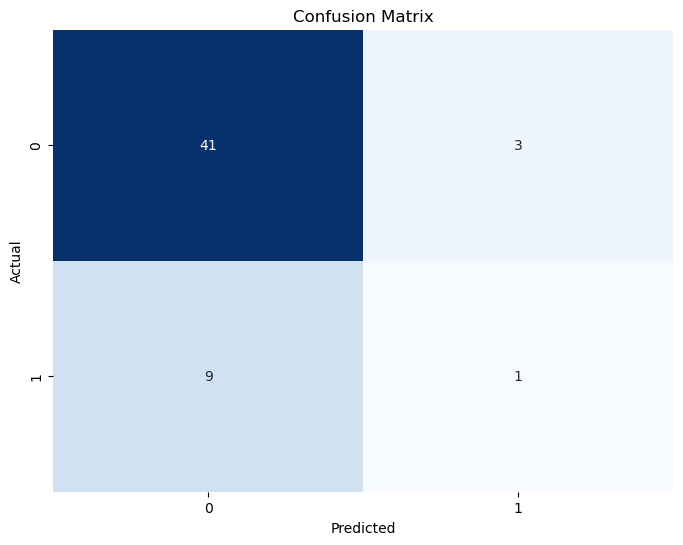

In [25]:
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)


false_negative_rate = conf_matrix[1, 0] / (conf_matrix[1, 0] + conf_matrix[1, 1] + conf_matrix[0, 0] + conf_matrix[0, 1])
false_positive_rate = conf_matrix[0, 1] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("Confusion Matrix:")
print(conf_matrix)
print(f"\nFalse Negative Rate: {false_negative_rate:.2%}")
print(f"False Positive Rate: {false_positive_rate:.2%}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

What was the most important feature for your model? Don't guess, either look up how to check or do your own tests.

**Most important feature:** Average review


In [26]:
feature_importances = rf_model.feature_importances_
most_important_index = feature_importances.argmax()
most_important_feature = X_train.columns[most_important_index]

print("Most Important Feature:", most_important_feature)

Most Important Feature: AveReview
